In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import transformers
from transformers import pipeline

In [127]:
df = pd.read_csv("Opal/Data/preprocessed_osteoporosis_prob.csv")

In [128]:
bin_age = []


for age in df['Age']:
    if age == '7-12':
        bin_age.append('0-44')
    elif age == '13-18':
        bin_age.append('0-44')
    elif age == '19-24':
        bin_age.append('0-44')
    elif age == '25-34':
        bin_age.append('0-44')
    elif age == '35-44':
        bin_age.append('0-44')
    elif age == '45-54':
        bin_age.append('45-54')
    elif age == '55-64':
        bin_age.append('55-64')
    elif age == '65-74':
        bin_age.append('65-74')
    elif age == '75 or over':
        bin_age.append('75+')
    else:
        #missing values
        bin_age.append('')

df['Age'] = bin_age

In [129]:
Review = []

for satisfaction in df['Satisfaction']:
    if satisfaction < 3:
        Review.append('bad')
    else:
        Review.append('good')

df['Review'] = Review

In [130]:
df['Sides'].unique

<bound method Series.unique of 0       Dizziness ,  lightheadedness , drowsiness, or ...
1       Stomach  upset,  nausea / vomiting ,  bloating...
2       Stomach  upset,  nausea / vomiting ,  bloating...
3             Constipation  or  stomach  upset may occur.
4             Constipation  or  stomach  upset may occur.
                              ...                        
1352          Constipation  or  stomach  upset may occur.
1353          Constipation  or  stomach  upset may occur.
1354          Constipation  or  stomach  upset may occur.
1355         Constipation  and  upset stomach  may occur.
1356    Vitamin D  at normal doses usually has no side...
Name: Sides, Length: 1357, dtype: object>

## n-gram helper functions

In [131]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#Enhanced stopwording
more_stopwords = {'went', 'go', 'one', 'two', '2', '3', 'side', 'effects'}
stopwords = stopwords.union(more_stopwords)

In [132]:
from collections import defaultdict
import nltk
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
"""import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
#nltk.word_tokenize(df_ost['Reviews'].iloc[0])

tokenizer = nltk.RegexpTokenizer(r"\w+")
#new_words = tokenizer.tokenize(df_ost['Reviews'].iloc[0])"""

'import nltk\nfrom collections import defaultdict\nfrom nltk.tokenize import word_tokenize\n#nltk.word_tokenize(df_ost[\'Reviews\'].iloc[0])\n\ntokenizer = nltk.RegexpTokenizer(r"\\w+")\n#new_words = tokenizer.tokenize(df_ost[\'Reviews\'].iloc[0])'

In [133]:
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string

In [134]:
def generate_ngrams(text, n_gram=1):
    from nltk.tokenize import word_tokenize
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    #text = tokenizer.tokenize(text)

    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    token = [remove_punc(i) for i in token]
    #token = [token for token in tokenizer.tokenize(text) if token != "" if token not in STOPWORDS]
    
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [135]:
## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Effectiveness

In [138]:
#have as probabilities instead of 0 or 1
df_effectiveness = df[df["effectiveness"]>0.7]

In [155]:
freq_dict = defaultdict(int)
for sent in df_effectiveness[df_effectiveness["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

freq_dict = defaultdict(int)
for sent in df_effectiveness[df_effectiveness["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Side Effects

In [140]:
#have as probabilities instead of 0 or 1
df_side_effects = df[df["side_effect"]>0.7]

In [157]:
freq_dict = defaultdict(int)
for sent in df_side_effects[df_side_effects["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

freq_dict = defaultdict(int)
for sent in df_side_effects[df_side_effects["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Classification

In [142]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

### Sample Experimentation

In [ ]:
#A sample review that contains a) whether the medicine worked b) the type of side effect and c) the delivery method (pill)

sample_review = "This osteoporosis medicine worked, but it gave me a nasty stomach ache. It was easy to swallow."


res = classifier(
    sample_review,
    candidate_labels = ['limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological', 'respiratory' , 'weight gain and loss', 'headache'], 
    multi_class = True
)
res

In [143]:
sides = ['limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological', 'respiratory' , 'weight gain and loss', 'headache']

In [159]:
#setting empty values for the columns
index = -1
for label in sides:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['Reviews'],
        candidate_labels = sides,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

In [161]:
print(len(df))
print(len(df_side_effects))

1357
1312


In [ ]:
#df.to_csv('data/updated_df.csv')

In [163]:
df['max'] = df[['limb pain_m', 'gastrointestinal_m', 'dental_m', 'cardiac_m', 'dermatological_m', 'respiratory_m', 'weight gain and loss_m', 'headache_m']].max(axis=1)
df.head()

,Unnamed: 0,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,...,Review,limb pain_m,gastrointestinal_m,dental_m,cardiac_m,dermatological_m,respiratory_m,weight gain and loss_m,headache_m,max
0,0,0-44,Osteoporosis,2010-03-16,lotensin,6883,4,3,this treatment is awsome. I love drugs.,2,...,bad,0.138630,0.057640,0.012045,0.090442,0.185604,0.196592,0.087278,0.151928,0.196592
1,1,45-54,Post-Menopausal Osteoporosis Prevention,2017-07-31,lopreeza,167327,5,2,After taking this drug for approx. 21 days I s...,3,...,good,0.044549,0.313618,0.009981,0.067002,0.222304,0.143084,0.031699,0.041735,0.313618
2,2,45-54,Post-Menopausal Osteoporosis Prevention,2016-12-29,lopreeza,167327,5,5,I have taken this drug for almost 7 years with...,5,...,good,0.052456,0.139045,0.058516,0.061539,0.294107,0.320504,0.059767,0.015010,0.320504
3,3,65-74,Osteoporosis,2010-05-26,liquid calcium + vitamin d,93396,5,5,since I have a hard time swallowing this hs wo...,5,...,good,0.002769,0.983138,0.369095,0.021584,0.012158,0.062320,0.263505,0.105072,0.983138
4,4,45-54,Osteoporosis,2012-01-19,oyster shell + d,94390,1,1,I have severe pain in my hand and muscle joint...,1,...,bad,0.999138,0.000104,0.000074,0.000637,0.001936,0.002675,0.002148,0.038169,0.999138


In [164]:
df_side_effects = df[df["side_effect"]>0.7]

In [185]:
df_side_effects = df_side_effects.reset_index()

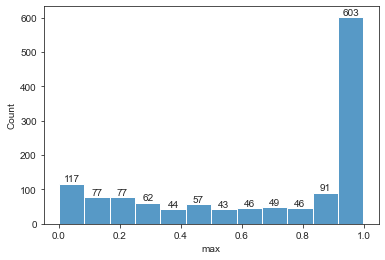

In [186]:
sns.set_style('ticks')
fig, ax = plt.subplots()
ax = sns.histplot(x = 'max', data = df_side_effects)
for container in ax.containers:
    ax.bar_label(container)

In [188]:
side1 = []
side2 = []
side3 = []
side4 = []
side5 = []
side6 = []
side7 = []
side8 = []
side9 = []

thresh = 0.7

for i in range(len(df_side_effects)):
    if df_side_effects['limb pain_m'][i] >= thresh:
        side1.append(1)
    elif df_side_effects['limb pain_m'][i] < thresh:
        side1.append(0)
    
    if df_side_effects['gastrointestinal_m'][i] >= thresh:
        side2.append(1)
    elif df_side_effects['gastrointestinal_m'][i] < thresh:
        side2.append(0)

    if df_side_effects['dental_m'][i] >= thresh:
        side3.append(1)
    elif df_side_effects['dental_m'][i] < thresh:
        side3.append(0)

    if df_side_effects['cardiac_m'][i] >= thresh:
        side4.append(1)
    elif df_side_effects['cardiac_m'][i] < thresh:
        side4.append(0)

    if df_side_effects['dermatological_m'][i] >= thresh:
        side5.append(1)
    elif df_side_effects['dermatological_m'][i] < thresh:
        side5.append(0)

    if df_side_effects['respiratory_m'][i] >= thresh:
        side6.append(1)
    elif df_side_effects['respiratory_m'][i] < thresh:
        side6.append(0)

    if df_side_effects['weight gain and loss_m'][i] >= thresh:
        side7.append(1)
    elif df_side_effects['weight gain and loss_m'][i] < thresh:
        side7.append(0)

    if df_side_effects['headache_m'][i] >= thresh:
        side8.append(1)
    elif df_side_effects['headache_m'][i] < thresh:
        side8.append(0)



df_side_effects['limb pain'] = side1
df_side_effects['gastrointestinal'] = side2
df_side_effects['dental'] = side3
df_side_effects['cardiac'] = side4
df_side_effects['dermatological'] = side5
df_side_effects['respiratory'] = side6
df_side_effects['weight'] = side7
df_side_effects['headache'] = side8


In [189]:
df_side_effects[df_side_effects['max'] > thresh]

,index,Unnamed: 0,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,...,headache_m,max,limb pain,gastrointestinal,dental,cardiac,dermatological,respiratory,weight,headache
2,4,4,45-54,Osteoporosis,2012-01-19,oyster shell + d,94390,1,1,I have severe pain in my hand and muscle joint...,...,0.038169,0.999138,1,0,0,0,0,0,0,0
3,5,5,75+,Osteoporosis,2015-02-23,os-cal 500-vit d3,16527,1,3,Food dyes and talc...large pill for a newly re...,...,0.001140,0.986400,0,0,0,0,0,1,0,0
4,6,6,45-54,Osteoporosis,2012-08-27,os-cal 500-vit d3,16527,5,3,I have taken it for 6 months and it did not in...,...,0.029188,0.873486,0,0,0,0,0,1,0,0
7,11,11,55-64,Post-Menopausal Osteoporosis Prevention,2008-02-13,"menostar patch, transdermal weekly",91304,5,5,I have been on menostar for three years and lo...,...,0.019342,0.932299,0,0,0,0,0,0,1,0
8,12,12,45-54,Post-Menopausal Osteoporosis Prevention,2018-02-20,"minivelle patch, transdermal semiweekly",162872,4,4,My first month on Minivelle patch was good. No...,...,0.103717,0.811494,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1350,1350,45-54,Post-Menopausal Osteoporosis Prevention,2010-11-23,"calcium 600 mg (1,500 mg) tablet",4155,2,1,"This is my only new mediciation, but I am noti...",...,0.012010,0.994845,1,0,0,0,0,0,0,0
1307,1352,1352,55-64,Osteoporosis,2010-11-15,calcium 600 + vitamin d,93224,4,5,The only thing I have to say against these tab...,...,0.190221,0.740947,0,1,0,0,0,0,0,0
1308,1353,1353,55-64,Osteoporosis,2016-03-16,calcium 500 + vitamin d,151589,4,4,Just started taking this a month ago. Definite...,...,0.001637,0.996667,0,1,0,0,0,0,0,0
1309,1354,1354,55-64,Osteoporosis,2012-03-08,calcitrate + vit d,19844,3,3,"This supplement has caused much gas, bloating,...",...,0.001705,0.993457,0,1,0,0,0,0,0,0


In [190]:
df_side_effects.to_csv('temp.csv', index = False)

In [191]:
df2 = df_side_effects[df_side_effects['max'] < 0.7]
df2

,index,Unnamed: 0,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,...,headache_m,max,limb pain,gastrointestinal,dental,cardiac,dermatological,respiratory,weight,headache
0,1,1,45-54,Post-Menopausal Osteoporosis Prevention,2017-07-31,lopreeza,167327,5,2,After taking this drug for approx. 21 days I s...,...,0.041735,0.313618,0,0,0,0,0,0,0,0
1,2,2,45-54,Post-Menopausal Osteoporosis Prevention,2016-12-29,lopreeza,167327,5,5,I have taken this drug for almost 7 years with...,...,0.015010,0.320504,0,0,0,0,0,0,0,0
5,7,7,55-64,Osteoporosis,2009-06-17,os-cal 500-vit d3,16527,5,5,"I am 64 years old, and am trying to avoid loss...",...,0.165314,0.244122,0,0,0,0,0,0,0,0
6,10,10,65-74,Post-Menopausal Osteoporosis Prevention,2014-06-16,menest,1792,4,4,I switched from Premarin to this medication an...,...,0.031087,0.670683,0,0,0,0,0,0,0,0
11,15,15,45-54,Post-Menopausal Osteoporosis Prevention,2014-04-25,"minivelle patch, transdermal semiweekly",162872,5,1,I have used the minivelle and developed severe...,...,0.002166,0.110276,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1343,1343,55-64,Post-Menopausal Osteoporosis Prevention,2009-07-23,c calcium,64799,5,3,"Even though I took the calcium as directed, I ...",...,0.008215,0.209177,0,0,0,0,0,0,0,0
1299,1344,1344,45-54,Osteoporosis,2008-08-05,c calcium,64799,5,5,I had lower back pain for 18 years. Five days ...,...,0.000952,0.003650,0,0,0,0,0,0,0,0
1304,1349,1349,65-74,Post-Menopausal Osteoporosis Prevention,2010-02-12,calcium 600 with soy,74961,5,5,I started taking this more than 10 years ago a...,...,0.051653,0.173584,0,0,0,0,0,0,0,0
1306,1351,1351,55-64,Post-Menopausal Osteoporosis Prevention,2010-11-20,calcium 600 + vitamin d,93224,1,2,"Abdominal swelling, nausea, bone pain, sorenes...",...,0.012038,0.570966,0,0,0,0,0,0,0,0


In [192]:
freq_dict = defaultdict(int)
for sent in df2[df2["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

freq_dict = defaultdict(int)
for sent in df2[df2["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [118]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

In [ ]:
sides2 = ['flu', 'body ache']


#setting empty values for the columns
index = -1
for label in sides2:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['Reviews'],
        candidate_labels = sides,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

In [125]:
#A sample review that contains a) whether the medicine worked b) the type of side effect and c) the delivery method (pill)

sample_review = "I have a serious back pain"


res = classifier(
    sample_review,
    candidate_labels = ['flu', 'body pain'], 
    multi_class = True
)
res

The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


{'sequence': 'I have a serious back pain',
 'labels': ['body pain', 'flu'],
 'scores': [0.9977540969848633, 6.392119394149631e-05]}